<div style="font-size: 16pt;">- Task 1: PCA analysis, number of principal components, biplot analysis</div><br/>
<div style="font-size: 16pt;">- Task 2: Compare logistic regression model performance with and without PCA</div><br/>
<div style="font-size: 16pt;">- Task 3: Use ROC to choose the best threshold for PCA-logistic regression model</div><br/><br/>


In [67]:
#load necessary packages
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.graphics.api as smg
from bioinfokit.visuz import cluster
import os
from sklearn.metrics import roc_curve
import seaborn as sns

In [2]:
#lending club data https://www.lendingclub.com/
#check file "LC_data dictionary" for data description
#only small subset of features used for the class, 
#full dataset size is more than 1GB 
df = pd.read_csv("data/LendingClub_small.csv")
df

,loan_status,loan_amnt,int_rate,emp_length,annual_inc,purpose,pub_rec,pub_rec_bankruptcies,home_mor,home_other,home_rent,home_own
0,0,30000,22.35,5.0,100000.0,debt_consolidation,1,1.0,1,0,0,0
1,0,40000,16.14,0.5,45000.0,credit_card,0,0.0,1,0,0,0
2,0,20000,7.56,15.0,100000.0,credit_card,0,0.0,1,0,0,0
3,0,4500,11.31,15.0,38500.0,credit_card,0,0.0,0,0,1,0
4,0,8425,27.27,3.0,450000.0,credit_card,0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1340968,1,18000,30.65,15.0,77000.0,debt_consolidation,0,0.0,1,0,0,0
1340969,0,17950,30.17,15.0,53758.0,debt_consolidation,1,1.0,1,0,0,0
1340970,0,15000,16.02,0.5,85000.0,debt_consolidation,0,0.0,0,0,1,0
1340971,1,21000,30.94,0.0,90000.0,medical,0,0.0,1,0,0,0


In [3]:
df.columns

Index(['loan_status', 'loan_amnt', 'int_rate', 'emp_length', 'annual_inc',
       'purpose', 'pub_rec', 'pub_rec_bankruptcies', 'home_mor', 'home_other',
       'home_rent', 'home_own'],
      dtype='object')

In [4]:
#get target (loan status) variable, drop columns not used 
loan_status = df['loan_status']
df.drop(['loan_status', 'purpose', 'pub_rec_bankruptcies'], axis=1, inplace=True)
df.columns

Index(['loan_amnt', 'int_rate', 'emp_length', 'annual_inc', 'pub_rec',
       'home_mor', 'home_other', 'home_rent', 'home_own'],
      dtype='object')

# Task 1: choose number of principal components, create and interpret biplot - 0.5 points

In [9]:
#standardize the features, set results to x
x = StandardScaler().fit_transform(df)

In [10]:
#check if mean is zero and std is 1
np.mean(x),np.std(x)

(1.396504519249959e-16, 1.000000000000002)

In [11]:
x.shape

(1340973, 9)

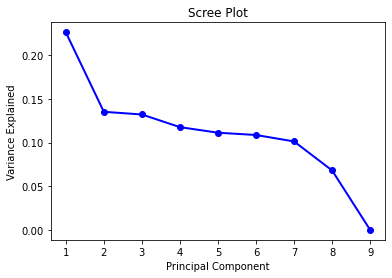

In [12]:
#choose number of principal components using scree plot (elbow plot)
n_components = x.shape[1]

pca_lc = PCA(n_components=n_components)
principalComponents_lc = pca_lc.fit_transform(x)

PC_values = np.arange(pca_lc.n_components_) + 1
plt.plot(PC_values, pca_lc.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()



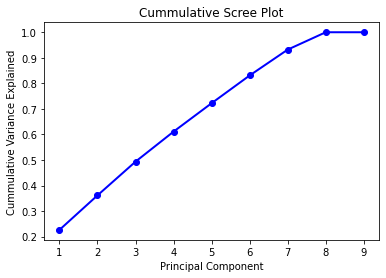

In [13]:
cum_pca_ev = np.cumsum(pca_lc.explained_variance_ratio_)
plt.plot(PC_values, cum_pca_ev, 'o-', linewidth=2, color='blue')
plt.title('Cummulative Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cummulative Variance Explained')
plt.show()

In [77]:
#generate biplot for the first two principal components 
labels = df.columns

#your code here
n_components = 2
pca_lc = PCA(n_components=n_components)
principalComponents_lc = pca_lc.fit_transform(x)
loadings = pca_lc.components_
loadings.shape


(2, 9)

In [78]:
# get 2D biplot, it is saved in the current folder (Python)
#code below assumes that you used pca_lc = PCA()
# and principalComponents_lc = pca_lc.fit_transform(x)
cluster.biplot(cscore=principalComponents_lc, loadings=loadings, labels=labels, \
               var1=round(pca_lc.explained_variance_ratio_[0]*100, 2), \
               var2=round(pca_lc.explained_variance_ratio_[1]*100, 2), axlabelfontsize = 10)

# Taska 2: compare model performance with and without PCA processing - 0.5 points

In [79]:
#features dataframe
df.head()

,loan_amnt,int_rate,emp_length,annual_inc,pub_rec,home_mor,home_other,home_rent,home_own
0,30000,22.35,5.0,100000.0,1,1,0,0,0
1,40000,16.14,0.5,45000.0,0,1,0,0,0
2,20000,7.56,15.0,100000.0,0,1,0,0,0
3,4500,11.31,15.0,38500.0,0,0,0,1,0
4,8425,27.27,3.0,450000.0,0,1,0,0,0


In [80]:
#target variable, labels: 0 - good loans, 1 - bad loans
loan_status

0          0
1          0
2          0
3          0
4          0
          ..
1340968    1
1340969    0
1340970    0
1340971    1
1340972    0
Name: loan_status, Length: 1340973, dtype: int64

In [81]:
#create train-test sets, test size = 0.2, random_state = 4, stratify = loan_status
x_train, x_test, y_train, y_test = train_test_split(
    df, loan_status, test_size=0.2, random_state=4, stratify=loan_status)

In [82]:
#check proportions on 1s
y_train.mean(), y_test.mean()

(0.22150528813976425, 0.22150673949924496)

In [83]:
x_train.mean()

loan_amnt     14468.122529
int_rate         13.316638
emp_length        7.287353
annual_inc    76192.678433
pub_rec           0.215903
home_mor          0.493453
home_other        0.000393
home_rent         0.398451
home_own          0.107704
dtype: float64

# Logistic regression

In [84]:
#Your logistic regression code here
model = LogisticRegression(random_state=100, solver='liblinear')
model.fit(x_train, y_train)
y_pred=model.predict(x_test)

In [85]:
#calculate confusion matrix, comment on most common bad predictions

cfm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
cfm = cfm / cfm.sum().sum()
cfm

Predicted,0,1
Actual,,
0,0.778046,0.000447
1,0.221350,0.000157


In [86]:
#calculate accuracy
accuracy = cfm.iloc[0,0] + cfm.iloc[1,1]
accuracy

0.7782024273383173

# PCA + logistic regression

In [87]:
y_train.mean(), y_test.mean()

(0.22150528813976425, 0.22150673949924496)

In [88]:
#standardize train and test sets

x_train_ss = StandardScaler().fit_transform(x_train)
x_test_ss = StandardScaler().fit_transform(x_test)
x_train_ss.shape, x_test_ss.shape

((1072778, 9), (268195, 9))

In [89]:
#run PCA for two different values for the number of principal components

pca_lc = PCA(n_components=2)
pca_train = pca_lc.fit_transform(x_train_ss)
pca_test = pca_lc.fit_transform(x_test_ss)
pca_train.shape, pca_test.shape

((1072778, 2), (268195, 2))

In [90]:
#run logisitic regression calculate confusion matrix

model = LogisticRegression(random_state=100, solver='liblinear')
model.fit(pca_train, y_train)
y_pred=model.predict(pca_test)
cfm = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
cfm = cfm / cfm.sum().sum()
cfm

Predicted,0,1
Actual,,
0,0.778031,0.000462
1,0.221350,0.000157


In [91]:
#calculate accuracy

accuracy = cfm.iloc[0,0] + cfm.iloc[1,1]
accuracy

0.7781875128171667

# Task 3: choose threshold for PCA + logistic regression model using ROC - 0.5 points

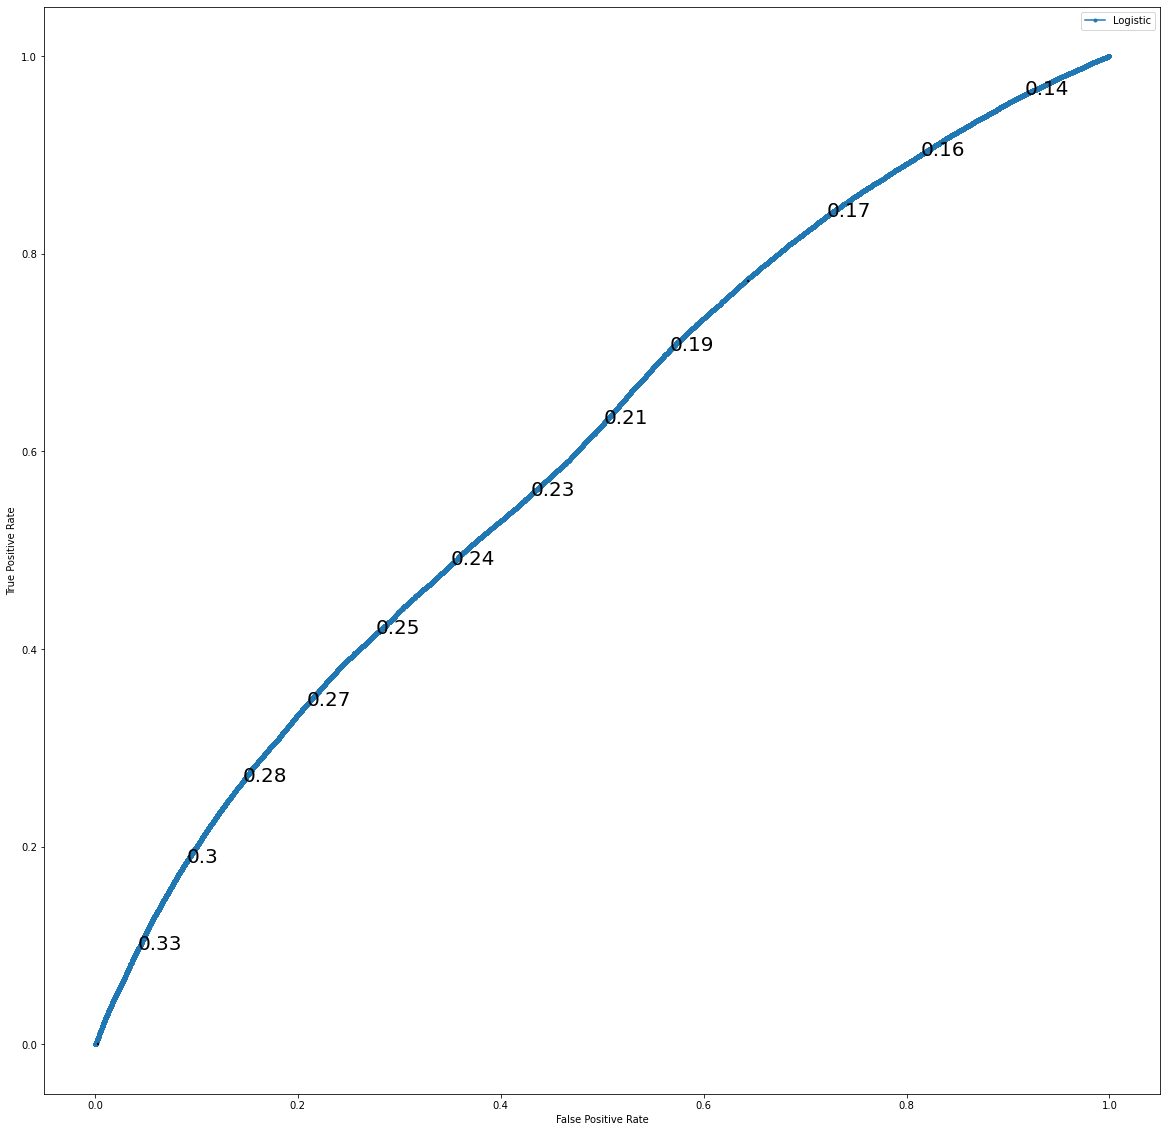

In [92]:
y_prob = model.predict_proba(pca_test)
y_prob = y_prob[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
str_thresholds = [str(round(x,2)) for x in thresholds]

sel = list(range(len(str_thresholds))[::10000])
for ind in sel:
    str_thresholds[ind] = '.'

plt.rcParams["figure.figsize"] = (20, 20)
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

counter = 0
for i in range(len(thresholds)): 
    if counter % 7000 == 0:
        plt.text(fpr[i], tpr[i], str_thresholds[i], fontsize=20)
    
    counter += 1

plt.show()

In [93]:
def calculate_confusion_matrix(y_test, y_prob, threshold):
    y_pred_t = 1*(y_prob >= threshold)
    cfm = pd.crosstab(y_test, y_pred_t, rownames=['Actual'], colnames=['Predicted'])
    cfm = cfm / cfm.sum().sum()
    sns.heatmap(cfm, annot=True)
    accuracy = cfm.iloc[0,0] + cfm.iloc[1,1]
    print("`Accuracy =  {:6.4f}".format(accuracy))
    return cfm, accuracy


`Accuracy =  0.5407


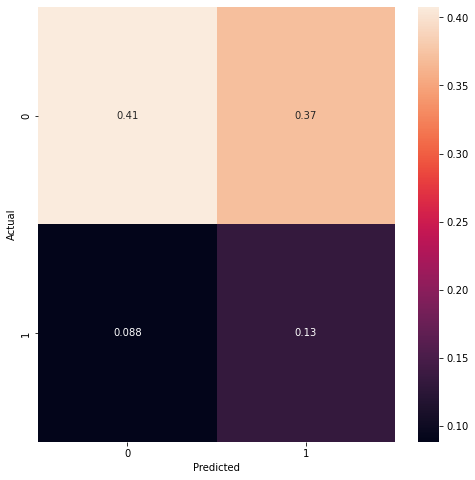

In [94]:
plt.rcParams["figure.figsize"] = (8, 8)
cfm , accuracy = calculate_confusion_matrix(y_test, y_prob, 0.215)